In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)


2.12.0


In [ ]:
import shutil
src_path = r"/home/fish/programing/cancerClassifier/patch_images/"
dst_path = r"/home/fish/programing/cancerClassifier/splitData/"

# split the dataset 
# dont runn unless you wanna split the data again (you dont)
with open('data_labels_mainData.csv', 'r') as file:
    
    for line in file.readlines()[1:]:
        li = line.split(',')
        shutil.copyfile(src_path + str(li[2]), dst_path + str(li[3]) + '/' + str(li[2]))
        print(li)
        



In [ ]:
import pathlib
dataset_url = "file:///home/fish/programing/cancerClassifier/splitData.tar.gz"
data_dir = tf.keras.utils.get_file('splitData', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)



In [30]:
batch_size = 32
img_height = 27
img_width = 27

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/splitData/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/fish/programing/cancerClassifier/splitData/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names

Found 9896 files belonging to 4 classes.
Using 7917 files for training.
Found 9896 files belonging to 4 classes.
Using 1979 files for validation.


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [32]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[10]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))



0.08627451 1.0


2023-04-25 15:57:58.565674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7917]
	 [[{{node Placeholder/_4}}]]
2023-04-25 15:57:58.566186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7917]
	 [[{{node Placeholder/_4}}]]


In [33]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [35]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 27, 27, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 27, 27, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          1

In [36]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10


2023-04-25 15:58:58.908841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7917]
	 [[{{node Placeholder/_4}}]]
2023-04-25 15:58:58.909140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7917]
	 [[{{node Placeholder/_4}}]]


241/248 [============================>.] - ETA: 0s - loss: 0.9768 - accuracy: 0.6021

2023-04-25 15:59:00.636954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1979]
	 [[{{node Placeholder/_4}}]]
2023-04-25 15:59:00.637198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1979]
	 [[{{node Placeholder/_4}}]]


248/248 [==============================] - 2s 6ms/step - loss: 0.9741 - accuracy: 0.6040 - val_loss: 0.7659 - val_accuracy: 0.7024
Epoch 2/10
248/248 [==============================] - 1s 5ms/step - loss: 0.7535 - accuracy: 0.7100 - val_loss: 0.7197 - val_accuracy: 0.7196
Epoch 3/10
248/248 [==============================] - 1s 5ms/step - loss: 0.7198 - accuracy: 0.7177 - val_loss: 0.7010 - val_accuracy: 0.7377
Epoch 4/10
248/248 [==============================] - 1s 5ms/step - loss: 0.7001 - accuracy: 0.7236 - val_loss: 0.6872 - val_accuracy: 0.7327
Epoch 5/10
248/248 [==============================] - 1s 5ms/step - loss: 0.6715 - accuracy: 0.7408 - val_loss: 0.6719 - val_accuracy: 0.7479
Epoch 6/10
248/248 [==============================] - 1s 5ms/step - loss: 0.6456 - accuracy: 0.7502 - val_loss: 0.6353 - val_accuracy: 0.7575
Epoch 7/10
248/248 [==============================] - 1s 5ms/step - loss: 0.6457 - accuracy: 0.7447 - val_loss: 0.6618 - val_accuracy: 0.7489
Epoch 8/10
248/24

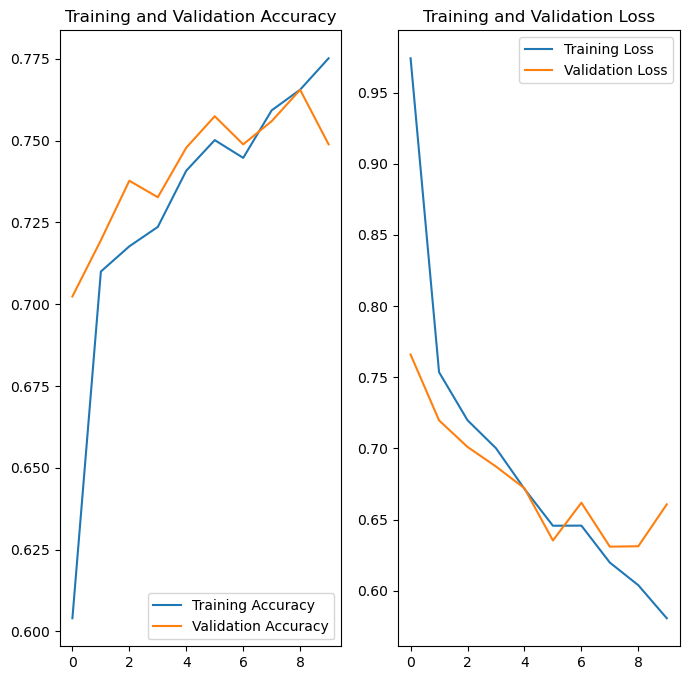

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
